Answer all questions and submit them either as an IPython notebook, LaTeX document, or Markdown document. Each question is worth 25 points.

This homework is due Tuesday, October 25, 2016.

In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
# import pylab as plt
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats.distributions import norm
import pylab as pl
from scipy.optimize import minimize
import seaborn as sns; sns.set_context('notebook')
from pymc3 import Normal, Binomial, Model, DensityDist, sample, Uniform, HalfCauchy, find_MAP
from pymc3.math import log, exp
from pymc3 import traceplot
from pymc3 import geweke
from pymc3 import forestplot
from pymc3 import gelman_rubin
from pymc3 import sample_ppc
from pymc3 import summary
from pymc3 import dic

# Set seed
np.random.seed(10011)

# Question 1

Epidemiologists are interested in studying the sexual behavior of individuals at risk for HIV infection. Suppose 1500 gay men were surveyed and each was asked how many risky sexual encounters he had in the previous 30 days. Let $n_i$ denote the number of respondents reporting $i$ encounters, for $i = 1, \ldots , 16$. The DataFrame below contains these reponses:

<AxesSubplot:>

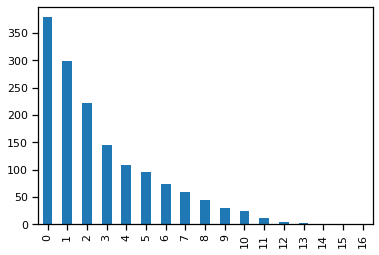

In [2]:
encounters = pd.DataFrame({'count': np.arange(17),
                          'freq': [379, 299, 222, 145, 109, 95, 73, 59,
                                  45, 30, 24, 12, 4, 2, 0, 1, 1]})

encounters.freq.plot.bar()

These data are poorly fitted by a Poisson model. It is more realistic to assume that the respondents comprise three groups. First, there is a group of people who, for whatever reason, report zero risky encounters even if this is not true. Suppose a respondent has probability $\alpha$ of belonging to this group. 

With probability $\beta$, a respondent belongs to a second group representing typical behavior. Such people respond truthfully, and their numbers of risky encounters are assumed to follow a $\text{Poisson}(\mu)$ distribution. 

Finally, with probability $1 − \alpha − \beta$, a respondent belongs to a high-risk group. Such people respond truthfully, and their numbers of risky encounters are assumed to follow a $\text{Poisson}(\lambda)$ distribution. 

The parameters in the model are $\alpha, \beta, \mu$ and $\lambda$. At the tth iteration of EM, we use $\theta^{(t)} = (\alpha^{(t)}, \beta^{(t)}, \mu^{(t)}, \lambda^{(t)})$ to denote the current parameter values. The likelihood of the observed data is given by:

$$L(\theta | n_0, \ldots, n_{16}) \propto \prod_{i=0}^{16} \left[ \frac{\pi_i(\theta)}{i!} \right]^{n_i}$$

where $\pi_i(\theta) = \alpha 1_{(i=0)} + \beta \mu^i \exp(-\mu) + (1-\alpha - \beta) \lambda^i \exp(-\lambda)$.

The observed data are in the `encounters` table above; the *complete* data may be construed to be $(n_{z,0}, n_{t,0}, n_{p,0}), \ldots, (n_{z,16}, n_{t,16}, n_{p,16})$, where $k = z, t, p$ correspond to zero, typical and promiscuous groups, respectively. That is, $n_0 = n_{z,0} + n_{t,0} + n_{p,0}$, and so on. Let $N = \sum_{i=0}^{16} n_i = 1500$.

Also define:

$$\begin{align}
z_0(\theta) &=& \frac{\alpha}{\pi_0(\theta)} \\
t_i(\theta) &=& \frac{\beta \mu^i \exp(-\mu)}{\pi_i(\theta)} \\
p_i(\theta) &=& \frac{(1-\alpha-\beta)\lambda^i \exp(-\lambda)}{\pi_i(\theta)}
\end{align}$$

which correspond to probabilities that respondents with $i$ risky encounters belong to various groups.

a. Show that the EM algorithm provides the following updates:

$$\begin{align}
\alpha^{(t+1)} &=& \frac{n_0 z_0(\theta^{(t)})}{N} \\
\beta^{(t+1)} &=& \sum_i \frac{n_i t_i(\theta^{(t)})}{N} \\
\mu^{(t+1)} &=& \frac{\sum_i i n_i t_i(\theta^{(t)})}{\sum_i n_i t_i(\theta^{(t)})} \\
\lambda^{(t+1)} &=& \frac{\sum_i i n_i p_i(\theta^{(t)})}{\sum_i n_i p_i(\theta^{(t)})}
\end{align}$$


b. Extimate the parameters of the model using the observed data.


# problem #1a Solution:
\begin{align}
L(\theta|n_1,\ldots,n_{16}) &\propto\prod_{i=0}^{16} \left[\frac{\pi_i(\theta)}{i!}\right]^{n_i}\\
\pi_i(\theta) &= \alpha \delta(i) + \beta \mu^i \exp(-\mu) + (1 - \alpha - \beta)\lambda^i exp(-\lambda)\\
\tilde{z}_0 &= \frac{\alpha}{\pi_0(\theta)}\\
t_i &= \frac{\beta \mu_i \exp(-\mu)}{\pi_i(\theta)}\\
p_i &= \frac{(1 - \alpha- \beta)\lambda^i \exp(-\lambda)}{\pi_i(\theta)}
\\
\\
L(\theta|n_1,\ldots,n_{16}) &\propto \sum_{i=0}^{16} n_i [\log \pi_i(\theta) - \log (2!)]\\
&= \sum_{i = 0}^{16} n_i \log [\alpha \delta(i) + \beta \mu^i \exp(-\mu) + (1-\alpha-\beta)\lambda^i \exp(-\lambda)]
-\sum_{i=0}^{16}\log(z!)\\
&= \sum_i \log E_{Q_i}\left[\frac{P(x_i,z_i|\theta)}{Q_i(z_i)}\right]\\
& \geq \sum_i E_{Q_i} \log \left[\frac{P(x_i,z_i|\theta)}{Q_i(z_i)}\right]\\
&= \sum_i\sum_{z_i} Q_i(z_i) \left[\frac{P(x_i,z_i|\theta)}{Q_i(z_i)}\right]\\
&= n_i \sum_i \left(\tilde{z}_i \log \frac{\pi_i(\theta)}{\tilde{z}_i}+ t_i  \log \frac{\pi_i(\theta)}{t_i} + 
                    p_i  \log \frac{\pi_i(\theta)}{p_i}\right) - n_i\sum_i\sum_{z_i}\log(i!)\\
&= n_0 \left(\tilde{z_0} \log \frac{\pi_0(\theta)}{\tilde{z}_0} + t_0  \log \frac{\pi_0(\theta)}{t_0} +
            p_0  \log \frac{\pi_0(\theta)}{p_0} \right) +
\sum_{i=0}^{16} n_i \left(t_i  \log \frac{\pi_i(\theta)}{t_i} +  p_i  \log \frac{\pi_i(\theta)}{p_i}\right)
\\
\\
\end{align}

Let $\Gamma = n_0 \left(\tilde{z_0} \log \frac{\pi_0(\theta)}{\tilde{z}_0} + t_0  \log \frac{\pi_0(\theta)}{t_0} +
            p_0  \log \frac{\pi_0(\theta)}{p_0} \right) +
\sum_{i=0}^{16} n_i \left(t_i  \log \frac{\pi_i(\theta)}{t_i} +  p_i  \log \frac{\pi_i(\theta)}{p_i}\right)$.

Then,

$$\Gamma = n_0 \left(\tilde{z_0} \log \frac{\alpha}{\tilde{z}_0^2} + t_0  \log \frac{\beta e^{-\mu}}{t_0^2} +
            p_0  \log \frac{(1-\alpha-\beta)e^{-\lambda}}{p_0^2} \right) +
\sum_{i=0}^{16} n_i \left(t_i  \log \frac{\beta \mu^i e^{-\mu}}{t_i^2} +
                          p_i  \log \frac{(1-\alpha-\beta)\lambda^i e^{-\lambda}}{p_i^2}\right).$$

To optimize $\Gamma$ with respect to the parameter values, we must compute 
$\partial L/\partial \alpha, \partial L/\partial \beta, \partial L/\partial \mu$, and $\partial L/\partial \lambda$.

\begin{align}
\frac{\partial \Gamma}{\partial \alpha} &= n_0 \tilde z_0 \frac{\tilde z_0^2}{\alpha}\cdot\frac{1}{\tilde z_0^2}+
n_0 p_0 \frac{p_0^2}{(1-\alpha-\beta)e^{-\lambda}}\cdot\frac{-e^{-\lambda}}{p_0^2} +
\sum_{i=1}^{16} n_i\left(p_i \frac{p_i^2}{(1-\alpha-\beta)\lambda^i 
                                          e^{-\lambda}}\cdot\left(\frac{-\lambda^i e^{-\lambda}}{p_i^2}\right)\right)\\
&= \frac{n_0 \tilde z_0}{\alpha} - \frac{n_0p_0}{1-\alpha-\beta}-\frac{1}{1-\alpha-\beta}\sum_{i=1}^{16} n_ip_i
\\
\\
\frac{\partial \Gamma}{\partial \beta} &= n_0t_0 \frac{t_0^2}{\beta e^{-\mu}}\frac{e^{-\mu}}{t_0^2} +
n_0p_0\frac{p_0^2}{(1-\alpha-\beta)e^{-\lambda}}\left(\frac{-e^{-\lambda}}{p_0^2} \right) +
\sum_{i=1}^{16}n_i\left(t_i\frac{t_i^2}{\beta\mu^i e^{-\mu}} \frac{\mu^i e^{-\mu}}{t_i^2} + 
p_i \frac{p_i^2}{(1-\alpha-\beta)\lambda^i e^{-\lambda}} \left(-\frac{\lambda^i e^{-\lambda}}{p_i^2}\right)
\right)\\
&= \frac{n_0t_0}{\beta} - \frac{n_0p_0}{1-\alpha-\beta} + 
\sum_{i=1}^{16}n_i\left(\frac{t_i}{\beta}-\frac{p_i}{1-\alpha-\beta}\right)
\\
\\
\frac{d\Gamma}{d\mu} &= n_0t_0 \frac{t_0^2}{\beta e^{-\mu}}\left(-\frac{\beta e^{-\mu}}{t_0^2}\right) +
\sum_{i=1}^{16} \left(t_i n_i \frac{t_i^2}{\beta\mu^i e^{-\mu}}\beta \frac{i \mu^{i-1}e^{-\mu}-\mu^ie^{-\mu}}{t_i^2}\right)\\
&= -n_0t_0 + \sum_{i=1}^{16} n_i t_i(i\mu^{-1}-1)\\
&= -n_0t_0 + \sum_{i=1}^{16} \frac{i n_i t_i}{\mu} - \sum_{i=1}^{16}n_it_i
\\
\\
\frac{\partial \Gamma}{\partial \lambda} &= n_0p_0 \frac{p_0^2}{(1-\alpha-\beta)e^{-\lambda}} 
\frac{-(1-\alpha-\beta)e^{-\lambda}}{p_0^2} + \sum_{i=1}^{16}n_ip_i \frac{p_i^2}{(1-\alpha-\beta)\lambda^ie^{-\lambda}}
\frac{(1-\alpha-\beta)(i\lambda^{i-1}e^{-\lambda}-\lambda^ie^{-\lambda})}{p_i^2}\\
&= -n_0p_0 + \sum_{i=1}^{16}(i \lambda^{-1}-1)n_ip_i\\
&= -n_0p_0 + \sum_{i=1}^{16}\frac{i n_ip_i}{\lambda}-\sum_{i=1}^{16}n_ip_i.
\end{align}

Now set these differential equations equal to zero and solve for the parameters ($\alpha$, $\beta$, $\lambda$, and $\mu$)

\begin{align}
\frac{n_0\tilde z_0}{\alpha} -\frac{n_0p_0}{1-\alpha\beta} -\frac{1}{1-\alpha-\beta}\sum_{i=1}^{16}n_ip_i=0
\\
\\
\frac{n_0t_0}{\beta} - \frac{n_0p_0}{1-\alpha-\beta} + \sum_{i=1}^{16}
                \{\frac{n_ip_i}{\beta} - \frac{n_ip_i}{1-\alpha-\beta}\} = 0 
\end{align}

For $\alpha$ and $\beta$ their respective equations (i and ii) are equivalent to:
    
\begin{align}
\frac{n_0\tilde z_0}{\alpha} -\frac{1}{1-\alpha-\beta}\sum_{i=0}^{16}n_ip_i=0
\\
\\
\sum_{i=0}^{16}\{\frac{n_ip_i}{\beta} - \frac{n_ip_i}{1-\alpha-\beta}\} = 0 
\end{align}

We can rewrite these equations as:
    
\begin{align}
(1-\alpha-\beta)n_0\tilde z_0 -\alpha\sum_{i=0}^{16}n_ip_i=0
\\
\\
(1-\beta)n_0\tilde z_0 = ( n_0\tilde z_0 + \sum_{i=0}^{16}n_ip_i )\alpha
\end{align}

Hence we have:

\begin{align}
\alpha = \frac{n_0\tilde z_0 (1 - \beta)}{n_0\tilde z_0 + \sum_{i=0}^{16}n_ip_i}
\end{align}

Also note that N is equivalent to the following (eqn iii):

\begin{align}
N = \sum_{i=0}^{16}n_it_i + \sum_{i=0}^{16}n_ip_i + n_0\tilde z_0 
\end{align}

                             
Also for (i) + (ii) we have $(n_0 \tilde{z}_0 + \sum_{i=0}^{16}n_it_i)  - (\alpha + \beta)({n_0 \tilde{z}_0 \sum_{i=0}^{16}n_it_i } + \sum_{i=0}^{16}n_ip_i) =0$

\begin{align}
\implies&  \alpha + \beta = \frac{  n_0\tilde{z}_0 + \sum_{i=0}^{16}n_it_i }{N} \\
\implies& \frac{n_0\tilde z_0(1- \beta)}{n_0\tilde{z}_0 + \sum_{i=0}^{16}n_ip_i} + \beta = 
                          \frac{n_0\tilde{z}_0 + \sum_{i=0}^{16}n_it_i}{N} \\
\implies& \beta\left(1-\frac{n_0\tilde{z}_0}{n_0\tilde z_0 + \sum_{i=0}^{16}n_ip_i}\right) = 
         \frac{n_0\tilde{z}_0 + \sum_{i=0}^{16}n_it_i}{N}-\frac{n_0 \tilde{z}_0}{n_0 \tilde{z}_0 + \sum_{i=0}^{16}n_ip_i}\\
\implies& \beta = \frac{n_0\tilde{z}_0 + \sum_{i=0}^{16}n_ip_i}{\sum_{i=0}^{16}n_ip_i}\left(
    \frac{n_0\tilde{z}_0 + \sum_{i=0}^{16}n_it_i}{N} - \frac{n_0\tilde{z}_0}{n_0\tilde{z}_0 + \sum_{i=0}^{16}n_ip_i}\right)\\
\implies& = \frac{1}{\sum_{i=0}^{16}n_ip_i}\frac{(n_0\tilde{z}_0 + \sum_{i=0}^{16}n_it_i)(n_0\tilde{z} +
\sum_{i=0}^{16}n_ip_i)}{N}-n_0\tilde{z}_0
\end{align}

Observe that $\frac{(n_0\tilde z_0 + \sum_{i=0}^{16}n_it_i)(n_0\tilde z +
\sum_{i=0}^{16}n_ip_i)}{N}-n_0\tilde z_0$ is equivalent to 
$\frac{1}{N}\left[(n_0\tilde z_0 + \sum_i n_i t_i) (n_0\tilde z_0 + \sum_i n_i p_i) - 
                  n_0\tilde z_0(n_0\tilde z_0 + \sum_i n_it_i + \sum_i n_ip_i)\right]$

Thus,
\begin{align}
\beta &= \frac{1}{N\sum_{i=0}^{16}n_ip_i}\left[(n_0\tilde z_0)^2 + n_0\tilde z_0\left(\sum_{i=1}^{16}n_it_i\right)+
                \left(\sum_{i=1}^{16} n_it_i\right)\left(\sum_{i=1}^{16} n_ip_i\right)-
                (n_0\tilde z_0)^2 - n_0\tilde z_0\left(\sum_{i=1}^{16}n_it_i\right)\right]\\
&= \frac{\sum_{i=1}^{16}n_it_i}{N}.
\end{align}

$\partial\Gamma/\partial \alpha = 0$ implies that

\begin{align}
\alpha &= \frac{n_0\tilde z_0(1-\beta)}{n_0\tilde z_0 + \sum_{i=1}^{16} n_ip_i}\\
&= \frac{n_0\tilde z_0\left(1-\sum_{i=1}^{16}n_it_i/N\right)}{n_0\tilde z_0 + \sum_{i=1}^{16} n_ip_i}\\
&= \frac{n_0\tilde z_0\left(n_0\tilde z_0+\sum_{i=1}^{16}n_it_i + 
                            \sum_{i=1}^{16}n_ip_i - \sum_{i=1}^{16}n_it_i\right)}{N\left(n_0\tilde z_0+\sum_{i=1}^{16}n_ip_i\right)}\\
&= \frac{n_0\tilde z_0}{N}\frac{n_0\tilde z_0 + \sum_{i=1}^{16}n_ip_i}{n_0\tilde z_0 + \sum_{i=1}^{16} n_ip_i}\\
&= \frac{n_0\tilde z_0}{N}
\end{align}

$\partial\Gamma/\partial \mu = 0$ implies that

\begin{align}
\frac{1}{\mu}\sum_{i=1}^{16} in_it_i &= \sum_{i=1}^{16} n_it_i\\
\implies \mu &= \frac{\sum_{i=1}^{16} in_it_i}{\sum_{i=1}^{16} n_i t_i}.
\end{align}

Finally, $\partial\Gamma/\partial \lambda = 0$ implies that

\begin{align}
\frac{1}{\lambda}\sum_{i=1}^{16} i n_ip_i &= \sum_{i=1}^{16}n_ip_i\\
\implies  \lambda&=\frac{\sum_{i=1}^{16}i n_i p_i}{\sum_{i=1}^{16}n_ip_i}.
\end{align}


### Define function which calculates the probabilities that respondents with risky encounters belongto the zero, typical and permiscuous groups.

In [3]:
#Problem #1b:

# Calculate the log
pi_i = lambda x, mu, lam, alpha, beta: alpha*(x<0.1)+beta*(mu**x)*np.exp(-mu)+(1-alpha-beta)*(lam**x)*np.exp(-lam)

# Calculate the probabilities that respondents with  𝑖  risky encounters belong to the z, t, p groups
#z, t, p  correspond to zero, typical and promiscuous groups, respectively
def e_step(x, alpha, beta, mu, lam):
    
    pi_0 = alpha + beta*np.exp(-mu)+(1-alpha-beta)*np.exp(-lam) 
    z0 = alpha/pi_0
    t_i = beta*(mu**x)*np.exp(-mu)/pi_i(x,mu,lam,alpha,beta) 
    p_i = (1-alpha-beta)*(lam**x)*np.exp(-lam)/pi_i(x,mu,lam,alpha,beta) 
    
    return z0,t_i,p_i

### Define function that determines parameters accorrding to their dependence on the probabilities $z_i$, $t_i$, $p_i$

In [4]:
#Calculate the parameters theta(alpha,beta, lambda, beta)
def m_step(x, n, z0,t_i,p_i,N=1500):

    alpha = n[0]*z0/N 
    beta = np.sum(t_i*n)/N
    mu = np.sum(n*x*t_i)/np.sum(n*t_i)
    lam = np.sum(n*x*p_i)/np.sum(n*p_i)
    
    return alpha, beta, mu, lam

### Calculate the model parameters

In [5]:
# Initialize values
mu = 4*np.random.random()
lam =  10*np.random.random()
alpha = 0.5*np.random.random()
beta = 0.5*np.random.random()

# Stopping criterion
crit = [1e-6,1e-6,1e-3,1e-3]
ii= 0
# Convergence flag
converged = False

# Loop until converged
while not converged:
    ii += 1
    # E-step
    z0, t_i, p_i = e_step(encounters['count'], alpha, beta, mu, lam )
    
    # M-step
    alpha_new, beta_new, mu_new, lam_new = m_step(encounters['count'], encounters['freq'], z0, t_i, p_i, N=1500)
 
        
    # Check convergence
    converged = ((np.abs(alpha_new - alpha) < crit[0]) 
                 & (np.abs(beta_new - beta) < crit[1])
                 & (np.abs(mu_new - mu) < crit[2])
                 & (np.abs(lam_new - lam) < crit[3]))
                 
    alpha, beta, mu, lam = alpha_new, beta_new, mu_new, lam_new
    if (ii==1000):
        (print('z0: {0}, \nt_i: {1}, \np_i: {2}'.format(
                z0, t_i, p_i)))
        
        (print('alpha_new: {0}, beta_new: {1}, mu_new: {2}, lambda_new: {3}'.format(
                alpha_new, beta_new, mu_new, lam_new)))
        
        (print('alpha: {0}, beta: {1}, mu: {2}, lambda: {3}'.format(
                alpha, beta, mu, lam)))
        ii=0
            
print('\n\nConverged!\nalpha: {0:.4f}, beta: {1:.4f}\nmu: {2:.4f}, lambda: {3:.4f}'.format(
                        alpha, beta, mu, lam))



Converged!
alpha: 0.1222, beta: 0.5625
mu: 1.4675, lambda: 5.9390


Text(0, 0.5, 'frequency')

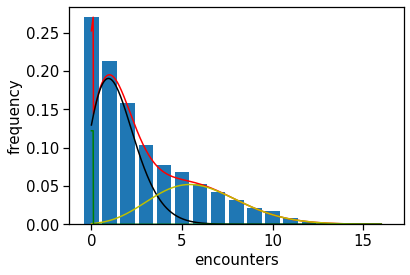

In [6]:
encntrs = np.linspace(0,16,1000)
like_hood = [pi_i(l,mu,lam,alpha,beta)/sp.special.factorial(l) for l in encntrs]

plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15
plt.bar(encounters['count'], np.max(like_hood)*encounters['freq']/np.max(encounters['freq']))
plt.plot(encntrs, like_hood, 'r')
plt.plot(encntrs, [beta*np.exp(-mu)*mu**l/sp.special.factorial(l) for l in encntrs],'k')
plt.plot(encntrs, [(1-alpha-beta)*np.exp(-lam)*lam**l/sp.special.factorial(l) for l in encntrs],'y')
plt.plot(encntrs, [alpha*(l<.1) for l in encntrs],'g')
plt.xlabel('encounters',fontsize=15)
plt.ylabel('frequency',fontsize=15)

# Question 2

Suppose $y$ has a binomial distribution with parameters $n$ and $p$, and we are interested in the log-odds value $\theta = \log(p/(1 − p))$. Our prior for $\theta$ is that $\theta \sim N(\mu, \sigma^2)$. It follows that the posterior density of $\theta$ is given, up to a proportionality constant, by:

$$\pi(\theta | y) \propto \frac{\exp(y\theta)}{(1 + exp(\theta))^n} \exp\left[\frac{-(\theta − \mu)^2}{2\sigma^2}\right]$$

For example, suppose we are interested in learning about the probability that a possibly-biased coin lands heads when tossed. *A priori* we believe that the coin is fair, so we assign $\theta$ a $N(0,.25)$ prior. We toss the coin $n = 5$ times and obtain $y = 5$ heads.

1. Using a normal approximation to the posterior density, compute the probability that the coin is biased toward heads (i.e., that θ is positive).
2. Using the prior density as a proposal density, design a rejection algorithm for sampling from the posterior distribution. Using simulated draws from your algorithm, approximate the probability that the coin is biased toward heads.
3. Using the prior density as a proposal density, simulate values from the posterior distribution using the SIR algorithm. Approximate the probability that the coin is biased toward heads.

In [7]:
# constants
n = 5              # number of trials
y = 5              # number of heads
MU   = 0.0         # prior mean
STDV = 0.5         # prior standard deviation

THETA_INIT = 0
THETAMIN = -2.0    # theta range
THETAMAX =  2.0

THETAMODE=  0.47   # mode (should be found by minimization)
THETASTDV=  0.50
SCALE    =  0.06

SAMPLES  = 200000    
# -----------------------------------------------
#convert theta to p
def theta2p(theta):
    p = 1./(1.+np.exp(-1.*theta))
    return p

def prior(theta, mu=MU, stdv=STDV):
    return np.exp(-0.5*((theta-mu)/stdv)**2)

def likelihood(y, n, theta):
    return np.exp(y*theta) / np.exp(n*np.log(1 + np.exp(theta)))

def posterior(theta, y, n, mu=MU, stdv=STDV):
    return likelihood(y, n, theta) * prior(theta,mu,stdv)

def logposterior_min(theta, y, n, mu=MU, stdv=STDV):
    return -np.log(posterior(theta, y, n))

def calc_diff_min(theta, post, y, n, mu=MU, stdv=STDV):
    return -(post(theta, y, n)/np.exp(-0.5*((theta-mu) / stdv)**2))

def envelope(theta,c=SCALE, mu=THETAMODE, stdv=THETASTDV):
    return c* np.exp(-0.5*((theta-mu) / stdv)**2)

def sampler_reject(likelihood, prior, y, n, thetamode, mu=THETAMODE, stdv=THETASTDV, samples=SAMPLES):
    theta = np.random.normal(MU, STDV, samples)
    p = likelihood(y, n, theta)/ likelihood(y, n, THETAMAX)
    u = np.random.uniform(0, 1, samples)
    return theta[u < p]

def sampler_sir(likelihood, prior, y, n, thetamode, mu=THETAMODE, stdv=THETASTDV, samples=SAMPLES):
    theta = np.random.normal(MU, STDV, samples)
    w = likelihood(y, n, theta)
    w_sum = sum(likelihood(y, n, theta))
    probs = w/w_sum
    theta_sir = theta[np.random.choice(range(len(theta)), size=100000, p=probs)]
    return theta_sir

### Calculate theta and p probabilities using standard minimization 

In this case the limited memory Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm was used. 

Theta_mode: 0.4783, Theta_SD: 0.4374
p_heads: 0.6173, p_SD: 0.6076


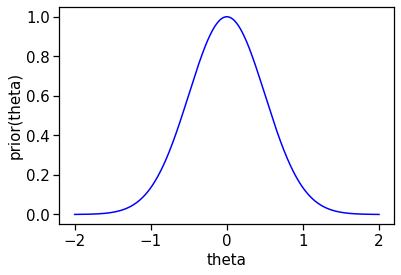

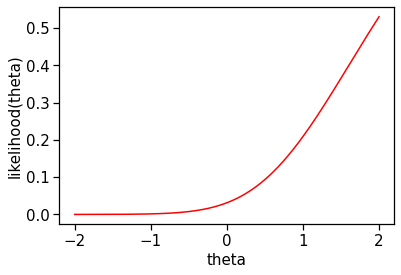

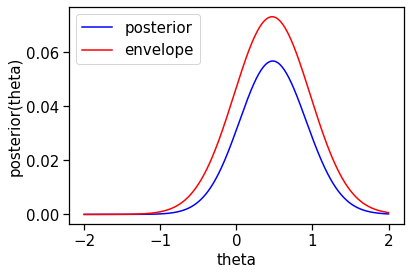

In [8]:
#minimize posterior and calculate descriptive statistics for theta and p
opt = minimize(logposterior_min, THETA_INIT, args=(y,n,MU,STDV), method='L-BFGS-B', jac = 0)

thetamode = opt.x
thetavar =  opt.hess_inv.todense()[0] 
thetastdv = np.sqrt(thetavar)
thetamin  = THETAMIN
thetamax  = THETAMAX

pmode = theta2p(thetamode)
psd = theta2p(thetastdv)

samples = SAMPLES
theta = np.linspace(-2, 2, samples)

#Calculate scale factor for the envelope 
opt = minimize(calc_diff_min, 0, args=(posterior, y,n,MU,STDV),method='L-BFGS-B', jac = 0)
c = 1/opt.x


print('Theta_mode: {0:.4f}, Theta_SD: {1:.4f}\np_heads: {2:.4f}, p_SD: {3:.4f}'.format(
                        thetamode[0], thetastdv[0], pmode[0], psd[0]))

plt.rcParams['xtick.labelsize']=15
plt.rcParams['ytick.labelsize']=15

# Plot Prior
plt.figure(1)
plt.plot(theta, prior(theta), '-b')
plt.xlabel('theta',fontsize = 15)
plt.ylabel('prior(theta)',fontsize = 15)

# Plot Likelihood
plt.figure(2)
plt.plot(theta, likelihood(y, n, theta), '-r')
plt.xlabel('theta',fontsize = 15)
plt.ylabel('likelihood(theta)',fontsize = 15)

# Plot Posterior and Envelope
plt.figure(3)
plt.plot(theta, posterior(theta, y, n), '-b')
plt.plot(theta, envelope(theta,c), '-r')
plt.xlabel('theta',fontsize = 15)
plt.ylabel('posterior(theta)',fontsize = 15)
plt.legend(['posterior','envelope'],loc = 'upper left',fontsize = 15)

### Calculate theta and p probabilities using a rejection algorithm 

Here an acceptance ratio is calculated using a ratio of likelihoods $L(\tilde{\theta}_{sample})/L(\tilde{\theta}_{max})$. The likehoods are calculated using i) theta sampled from a the proposal distribution for $L(\tilde{\theta}_{sample})$ and ii) theta set to value which is near the tail of the prior distribution for $L(\tilde{\theta}_{max})$. This acceptance ratio is then compared to a randomly generated number $u$. If the acceptance ratio exceeds $u$ then $\theta_{sample}$ is accepted. Note this algorithm favors sampling $\theta$ in high density regions of the calculated probability distribution of $\theta \sim N(\mu,\sigma)$ while only occasionally sampling from the tails of the distribution.

Simulated values using the rejection algorithm and the prior density for a proposal density
For 200000 samples the estimates are:
Estimated probability of heads: theta = 0.4762439
This is equivalent to a linear probability of p =  0.6168605


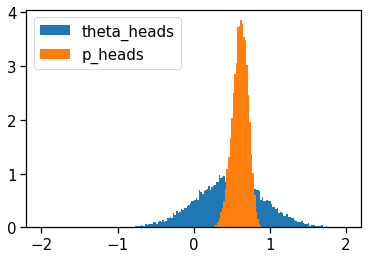

In [9]:
theta_sample1 = sampler_reject(likelihood, prior, y, n, thetamode)
p_sample1 = theta2p(theta_sample1)

bins = np.linspace(thetamin, thetamax, 200)
plt.hist(theta_sample1, bins, density=True)
plt.hist(p_sample1, bins, density=True)
plt.legend(['theta_heads','p_heads'],loc='upper left',fontsize = 15)

prob_theta1 = np.mean(theta_sample1)
prob_p1 = theta2p(prob_theta1)

print('Simulated values using the rejection algorithm and the prior density for a proposal density')
print('For {0} samples the estimates are:'.format(samples))
print('Estimated probability of heads: theta = {0:.7f}'.format(prob_theta1))
print('This is equivalent to a linear probability of p =  {0:.7f}'.format(prob_p1))

### Calculate theta and p probabilities using the SIR algor## Sampling Importance Resampling

Here we acquire a sample of size $N$ using a importance sampling distribution $r$ and calculate the corresponding weights $w(\theta_i) = p(\theta|y) / r(\theta)$. 

Rather then directly re-weighting the samples from $r$, the SIR method turns the weights into probabilities via:

$p_i = w(\theta_i)/\sum_{i=1}^M w(\theta_i)$

We then use these probabilities to re-sample with replacement the $\theta_i$ values. This results in the resampled  $\theta_i^{\prime}$ having s distribution approximately equivalent to the posterior $p(\theta|y)$.

Simulated values using the SIR algorithm and the prior density for a proposal density
For 200000 samples the estimates are:
Estimated probability of heads: theta = 0.4844863
This is equivalent to a linear probability of p = 0.6188067


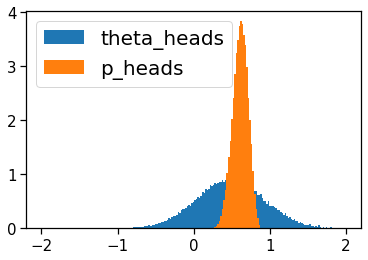

In [10]:
theta_sample2 = sampler_sir(likelihood, prior, y, n, thetamode)
p_sample2 = theta2p(theta_sample2)

plt.hist(theta_sample2, bins, density=True)
plt.hist(p_sample2, bins, density=True)
plt.legend(['theta_heads','p_heads'],loc='upper left',fontsize = 20)

prob_theta2 = np.mean(theta_sample2)
prob_p2 = theta2p(prob_theta2)

print('Simulated values using the SIR algorithm and the prior density for a proposal density')
print('For {0} samples the estimates are:'.format(samples))
print('Estimated probability of heads: theta = {0:.7f}'.format(prob_theta2))
print('This is equivalent to a linear probability of p = {0:.7f}'.format(prob_p2))

# Question 3

The goal of this problem is to investigate the role of the proposal distribution in a Metropolis-Hastings algorithm designed to simulate from the posterior distribution of the mixture parameter $\delta$. 

1. Simulate 200 realizations from the mixture distribution:
    $$y_i \sim \delta N(7, 0.5^2) + (1-\delta) N(10, 0.5^2)$$
    with $\delta = 0.7$. Plot a histogram of these data. 
2. Implement a random walk M-H algorithm with proposal $\delta^{\prime} = \delta^{(i)} + \epsilon$ with $\epsilon \sim Unif(−1,1)$. 
3. Reparameterize the problem letting $U = \log\left[\frac{\delta}{1 - \delta}\right]$ and $u^{\prime} = u^{(i)} + \epsilon$. Implement a random walk chain in U-space. 
4. Compare the estimates and convergence behavior of the three algorithms.

In part (1), you are asked to simulate data from a distribution with $\delta$ known. For parts (2)–(3), assume $\delta$ is unknown with prior $\delta \sim Unif( 0,1)$. For parts (2)–(3), provide an appropriate plot and a table summarizing the output of the algorithm. 

To facilitate comparisons, use the same number of iterations, random seed, starting values, and burn-in period for all implementations of the algorithm. 

<y> = 7.8957, <delta> = 0.7033, <delta_u> = 0.7039
The distribution of y and the delta_u distribution converge at a faster rate than the delta distribution
The reason why delta_u converges faster than delta is due to the lower acceptance rate of the delta relative to u


/Users/fermi/anaconda3/envs/fermi-learn/lib/python3.6/site-packages/ipykernel_launcher.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


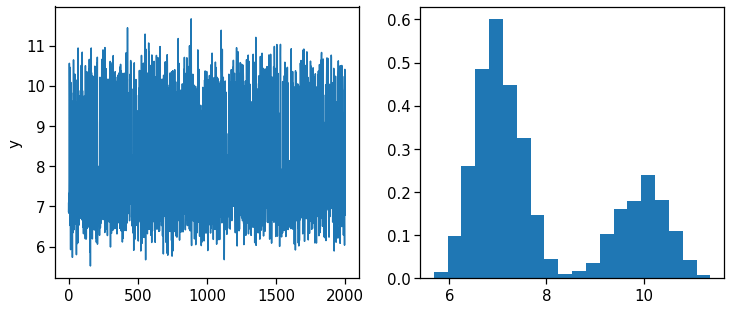

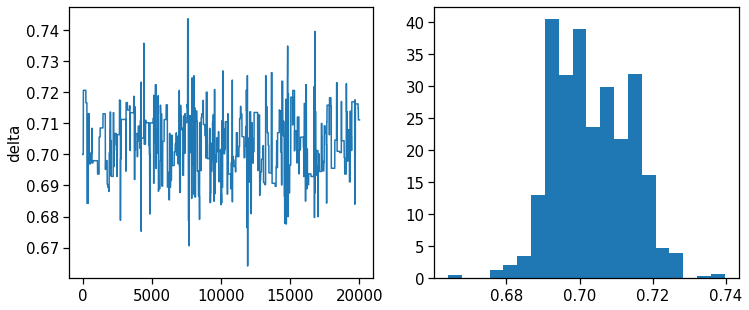

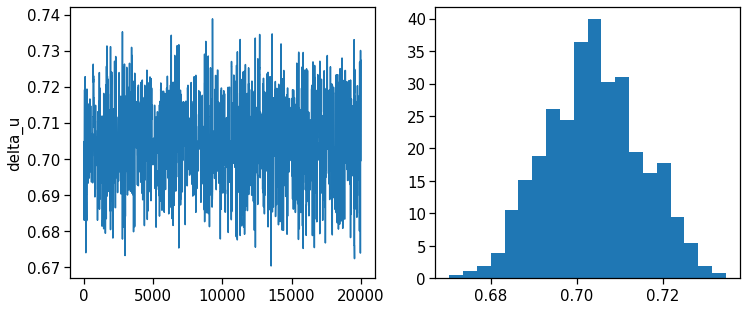

In [11]:
import pylab as plt

ITERATIONS = 20000
nsamples = 2000
delta = np.linspace(0,1, 3000)

def sample_mixture(nsamples = 200, delta=0.7,mu=[7,10],sd=[0.5,0.5]):
    u = np.random.uniform(0,1,nsamples)
    index = [0 if u[i] < delta else 1 for i in range(nsamples)]
    mean = [mu[i] for i in index]
    stdv = [sd[i] for i in index]
    return np.random.normal(mean,stdv)

def log_likelihood(delta,mix,mu=[7,10],sd=[0.5,0.5]):
    like = delta*norm.pdf(mix,mu[0],sd[0])+(1-delta)*norm.pdf(mix,mu[1],sd[1])
    log_like = np.log( like ) 
    return sum(log_like)

def u2delta(theta):
    p = 1./(1.+np.exp(-1.*theta))
    return p

def ulog_likelihood(u,mix,mu=[7,10],sd=[0.5,0.5]):
    like = u2delta(u)*norm.pdf(mix,mu[0],sd[0])+(1-u2delta(u))*norm.pdf(mix,mu[1],sd[1])
    log_like = np.log( like ) 
    return sum(log_like)

def markov_chain(log_like,mix,mu=[7,10],sd=[0.5,0.5], delta= 0.7,  iterations=20000):
    delta_array = []
    
    loglike_cur = log_like(delta,mix,mu,sd)
    for i in range(iterations): 
        e = np.random.uniform(-1,1)
        delta_proposal = delta + e
       
        loglike_prop = log_like(delta_proposal,mix,mu,sd)
        p = np.exp(loglike_prop-loglike_cur)
        u =  np.random.uniform() 
        
        if ( u < p):
            delta = delta_proposal
            loglike_cur = loglike_prop    
            delta_array.append(delta)
        else: 
            delta_array.append(delta)
    
    return delta_array

def umarkov_chain(ulog_like,mix,mu=[7,10],sd=[0.5,0.5], delta= 0.7,  iterations=20000):
    
    u = np.log(delta)-np.log(1-delta)
    u_array = []
    loglike_cur = ulog_like(u,mix,mu,sd)
   
    
    for i in range(iterations): 
        e = np.random.uniform(-1,1)
        u_proposal = u + e
        
        loglike_prop = ulog_like(u_proposal,mix,mu,sd)
        p = np.exp(loglike_prop-loglike_cur)
        uni =  np.random.uniform() 
        if ( uni < p):
            u = u_proposal
            loglike_cur = loglike_prop    
            u_array.append(u)
        else: 
            u_array.append(u)
            
    delta_array = u2delta(np.array(u_array))
    return delta_array


mix = sample_mixture(nsamples)
itns = ITERATIONS

mark_array = markov_chain(log_likelihood,mix,iterations=itns)            
umark_array = umarkov_chain(ulog_likelihood,mix, iterations=itns)            

lmix = len(mix)
lmark = len(mark_array)  
ulmark = len(umark_array)

#Indices for burn in
mj = int(lmix/2)
uj = int( ulmark/2)
j = int( lmark/2)       


print('<y> = {0:.4f}, <delta> = {1:.4f}, <delta_u> = {2:.4f}'.format(np.mean(mix), 
                                     np.mean(mark_array[j:]),np.mean(umark_array[uj:]) ) )

print('The distribution of y and the delta_u distribution converge at a faster rate than the delta distribution')
print('The reason why delta_u converges faster than delta is due to the lower acceptance rate of the delta relative to u')


trace = [mix,mark_array,umark_array]
for param, samples, n_iter in zip(['y', 'delta', 'delta_u'], np.array(trace).T, [mj,j,uj]):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].plot(samples)
    axes[0].set_ylabel(param,fontsize=15)
    axes[1].hist(samples[int(n_iter):],bins = 20, density = True)
    

# Question 4

Carlin (1992) considers a Bayesian approach to meta-analysis, and includes the following examples of 22 trials of beta-blockers to prevent mortality after myocardial infarction. These data are given below.

In one possible random effects model we assume the true baseline mean (on a log-odds scale) $m_i$ in a trial $i$
is drawn from some population distribution. Let $r^C_i$ denote number of events in the control group in trial $i$, and $r^T_i$ denote events under active treatment in trial $i$. Our model is:

$$\begin{aligned}
r^C_i &\sim \text{Binomial}\left(p^C_i, n^C_i\right) \\
r^T_i &\sim \text{Binomial}\left(p^T_i, n^T_i\right) \\
\text{logit}\left(p^C_i\right) &= \mu_i \\
\text{logit}\left(p^T_i\right) &= \mu_i + \delta \\
\mu_i &\sim \text{Normal}(m, s).
\end{aligned}$$

In this case, we want to make inferences about the population effect $m$, and the predictive distribution for the effect $\delta_{\text{new}}$ in a new trial. 

This particular model uses a random effect for the population mean, and a fixed effect for the treatment effect. There are 3 other models you could fit to represent all possible combinations of fixed or random effects for these two parameters.

Build all 4 models to estimate the treatment effect in PyMC3 and 

1. use convergence diagnostics to check for convergence in each model 
2. use posterior predictive checks to compare the fit of the models
3. use DIC to compare the models as approximations of the true generating model

Which model would you select and why?

In [12]:
r_t_obs = np.array([3, 7, 5, 102, 28, 4, 98, 60, 25, 138, 64, 45,
                    9, 57, 25, 33, 28, 8, 6, 32, 27, 22])
n_t_obs =  np.array([38, 114, 69, 1533, 355, 59, 945, 632, 278,1916, 
                     873, 263, 291, 858, 154, 207, 251, 151, 174, 209, 391, 680])
r_c_obs =  np.array([3, 14, 11, 127, 27, 6, 152, 48, 37, 188, 52, 47, 
                     16, 45, 31, 38, 12, 6, 3, 40, 43, 39])
n_c_obs =  np.array([39, 116, 93, 1520, 365, 52, 939, 471, 282, 1921, 
                     583, 266, 293, 883, 147, 213, 122, 154, 134, 218, 364, 674])
N = len(n_c_obs)

In [24]:
invlogit = pm.math.invlogit
logit = pm.math.logit
observ = np.arange(0, N, 1)
NSAMPLES = 2500
NCORES = 4
BINS = int(nsamples/10)
varnames1=['m', 'mu', 'delta']
varnames2=['d','delta','mu']
varnames3=['mu','delta']
varnames4=[ 'm','mu', 'd','delta']

def model_tester(trace, varnames, sim, model_DIC, data=[r_c_obs,r_t_obs]):
    traceplot(trace, varnames)
    #gelman_rubin(trace)
    plt.figure(3)
    forestplot(trace)

    fig, axes = plt.subplots(22,1,  figsize=(8, 80))
    #bins = int(np.array(np.shape(sim))/10)
    for obsc, simc, ax in zip(data[0],sim['r_c'].T,axes):
        ax.hist(simc, bins=50,label='control')
        ax.plot(obsc+0.5, 1, 'ro', label='c_mean')

    for obst, simt, ax in zip(data[1], sim['r_t'].T,axes):
        ax.hist(simt, bins=50, label='treatment')
        ax.plot(obst+0.5, 1, 'ko',label='t_mean')
        ax.legend(loc=1)
       #ax.set_title('Treatment & Control Trial: mu_c = {0}'.format(obst))

    print ( '\nThe DIC for this model is {0:.5f}'.format(model_DIC) )
    #summary(bblock_survival1_trace [500:], varnames=['m','delta','mu'])

    return


with Model() as bblock_survival1:
   
    m = Normal("m", 0, sd = 100)
    mu_sd = HalfCauchy("mu_sd",4)
    mu = Normal("mu", m, sd = mu_sd, shape = N)

    delta = Uniform("delta", lower=-10, upper=10)

    p_c = invlogit( mu[observ] )
    p_t = invlogit( mu[observ] + delta )

    r_c = Binomial("r_c", np.array(n_c_obs), p = p_c, observed = np.array(r_c_obs))
    r_t = Binomial("r_t", np.array(n_t_obs), p = p_t, observed = np.array(r_t_obs))

    start_pt = find_MAP(model=bblock_survival1)
    bblock_survival1_trace = sample(NSAMPLES, cores=NCORES, start = start_pt)
    bbsim1 = sample_ppc(bblock_survival1_trace, samples=NSAMPLES)   
    bbmodel1_dic = dic( bblock_survival1_trace )




with Model() as bblock_survival2:

    d = Normal("d", 0, sd = 100)
    d_sd = HalfCauchy("d_sd",4)
    delta = Normal("delta",d, sd = d_sd, shape = N)

    mu = Uniform("mu", lower=-10, upper=10)

    p_c = invlogit( mu )
    p_t = invlogit( mu + delta[observ] )

    r_c = Binomial("r_c", np.array(n_c_obs), p = p_c, observed = np.array(r_c_obs))
    r_t = Binomial("r_t", np.array(n_t_obs), p = p_t, observed = np.array(r_t_obs))

    start_pt = find_MAP(model = bblock_survival2)
    bblock_survival2_trace = sample(NSAMPLES, njobs=NCORES, start = start_pt)
    bbsim2 = sample_ppc(bblock_survival2_trace, samples=NSAMPLES)   
    bbmodel2_dic = dic( bblock_survival2_trace)



with Model() as bblock_survival3:

    delta = Uniform("delta", lower=-10, upper=10)
    mu = Uniform("mu", lower=-10, upper=10)

    p_c = invlogit( mu )
    p_t = invlogit( mu + delta )

    r_c = Binomial("r_c", np.array(n_c_obs), p = p_c, observed = np.array(r_c_obs))
    r_t = Binomial("r_t", np.array(n_t_obs), p = p_t, observed = np.array(r_t_obs))

    start_pt = find_MAP(model = bblock_survival3)
    bblock_survival3_trace = sample(NSAMPLES, njobs=NCORES, start = start_pt)
    bbsim3 = sample_ppc(bblock_survival3_trace, samples=NSAMPLES)   
    bbmodel3_dic = dic( bblock_survival3_trace)




with Model() as bblock_survival4:
    
    d = Normal("d", 0, sd = 100)
    d_sd = HalfCauchy("d_sd",4)
    delta = Normal("delta",d, sd = d_sd, shape = N)


    m = Normal("m", 0, sd = 100)
    mu_sd = HalfCauchy("mu_sd", 4)
    mu = Normal("mu", m, sd = mu_sd, shape = N)

    p_c = invlogit( mu )
    p_t = invlogit( mu + delta )

    r_c = Binomial("r_c", np.array(n_c_obs), p = p_c, observed = np.array(r_c_obs))
    r_t = Binomial("r_t", np.array(n_t_obs), p = p_t, observed = np.array(r_t_obs))

    #start_pt = find_MAP(model = bblock_survival4)
    bblock_survival4_trace = (sample(NSAMPLES, njobs=NCORES, 
                             start=[{'delta':-.5}, {'delta':-.7}, {'delta':-.3}, {'delta':-.4},
                             {'mu':-2}, {'mu':-3}, {'mu':-2.5}, {'mu':-2.25}]))
    bbsim4 = sample_ppc(bblock_survival4_trace, samples= NSAMPLES)   
    bbmodel4_dic = dic( bblock_survival4_trace)   



## Summary for model #1. Here delta is deterministic and mu is stochastic. 

This model is the preferred model out of all four since it has the lowest DIC. 

The following is a summary for model #1, where delta is a deterministic and mu is a stochastic variable

The DIC for this model is 340.61038
All these models converge according to the gelman-rubin test

This is the best of the four models since it has the lowest DIC score and the best fits


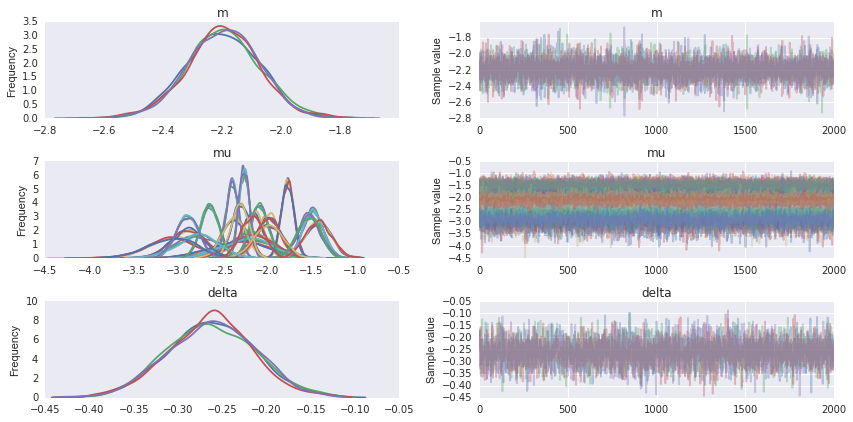

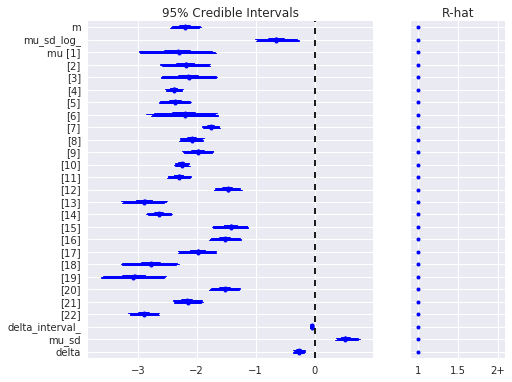

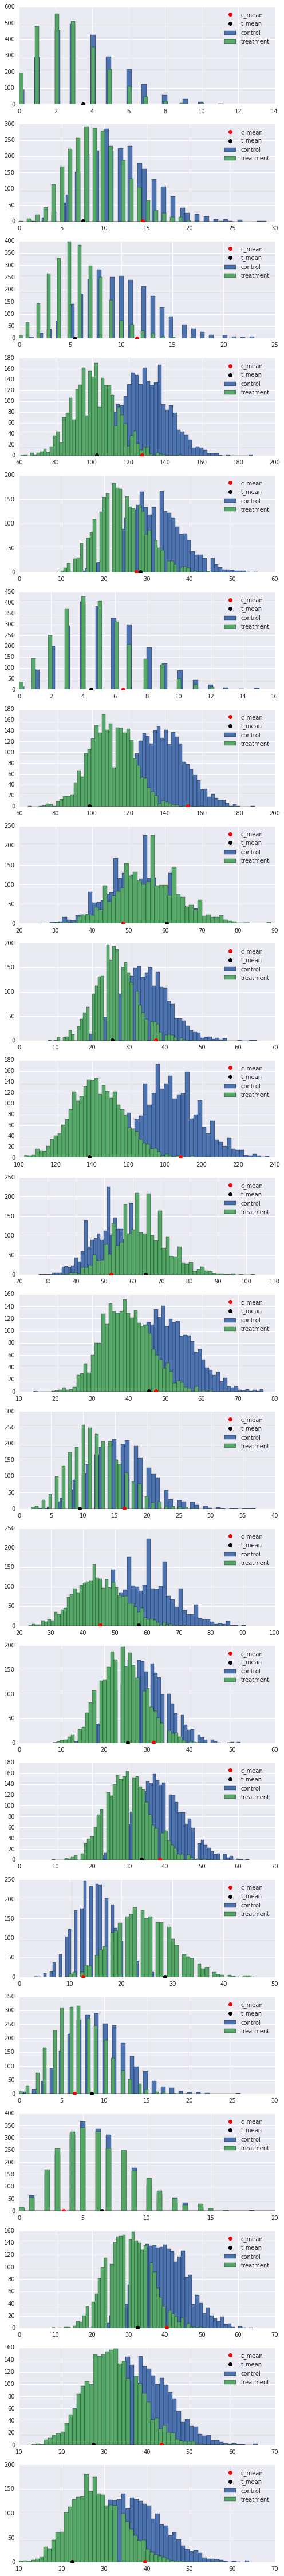

In [20]:
print('The following is a summary for model #1, where delta is a deterministic and mu is a stochastic variable')
model_tester(bblock_survival1_trace[500:],varnames1,  bbsim1, bbmodel1_dic)
print('All these models converge according to the gelman-rubin test')
print('\nThis is the best of the four models since it has the lowest DIC score and the best fits')

## Summary for model #2. Here delta is stochastic and mu is deterministic. 

The following is a summary for model #2, where mu is a deterministic and delta is a stochastic variable

The DIC for this model is 492.18215


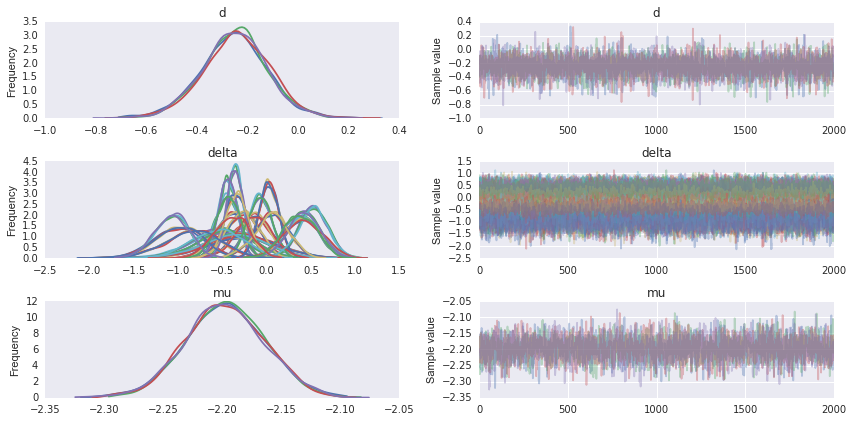

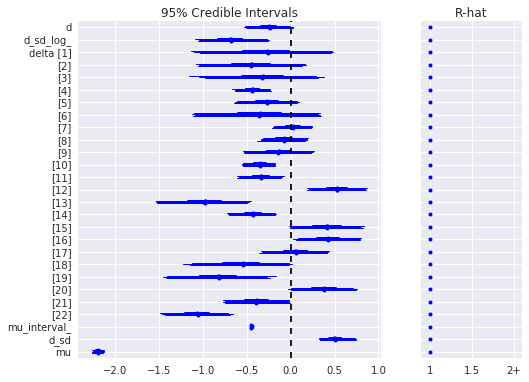

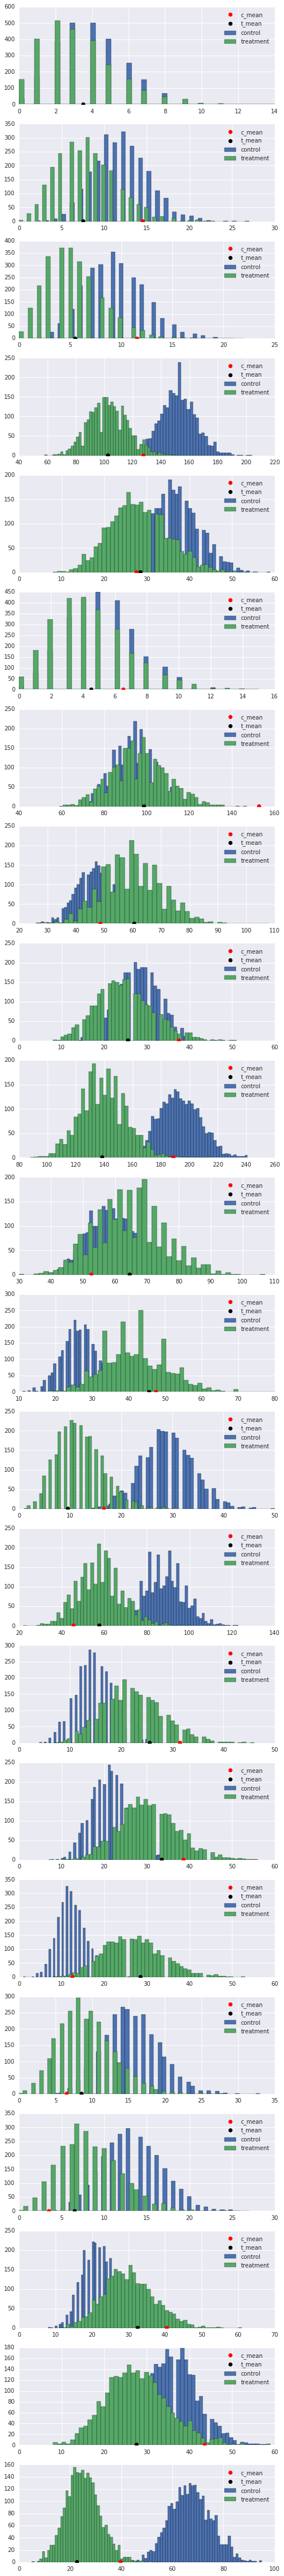

In [17]:
print('The following is a summary for model #2, where mu is a deterministic and delta is a stochastic variable')
model_tester(bblock_survival2_trace[500:],varnames2,  bbsim2, bbmodel2_dic)

## Summary for model #3. Here delta and mu is deterministic. 

The following is a summary for model #3, where mu and delta are deterministic variables

The DIC for this model is 532.82704


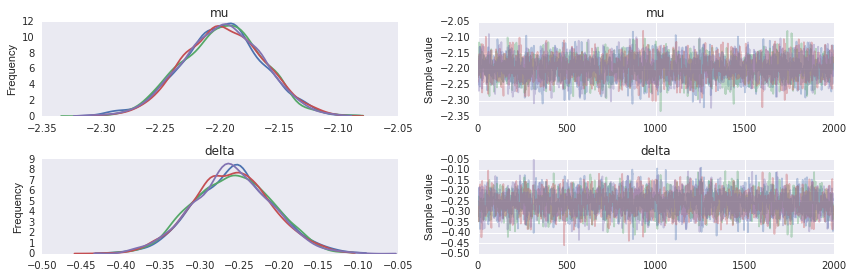

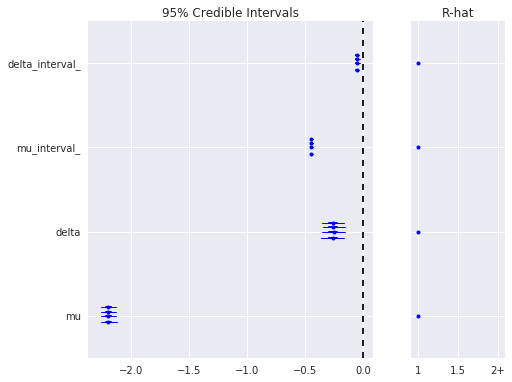

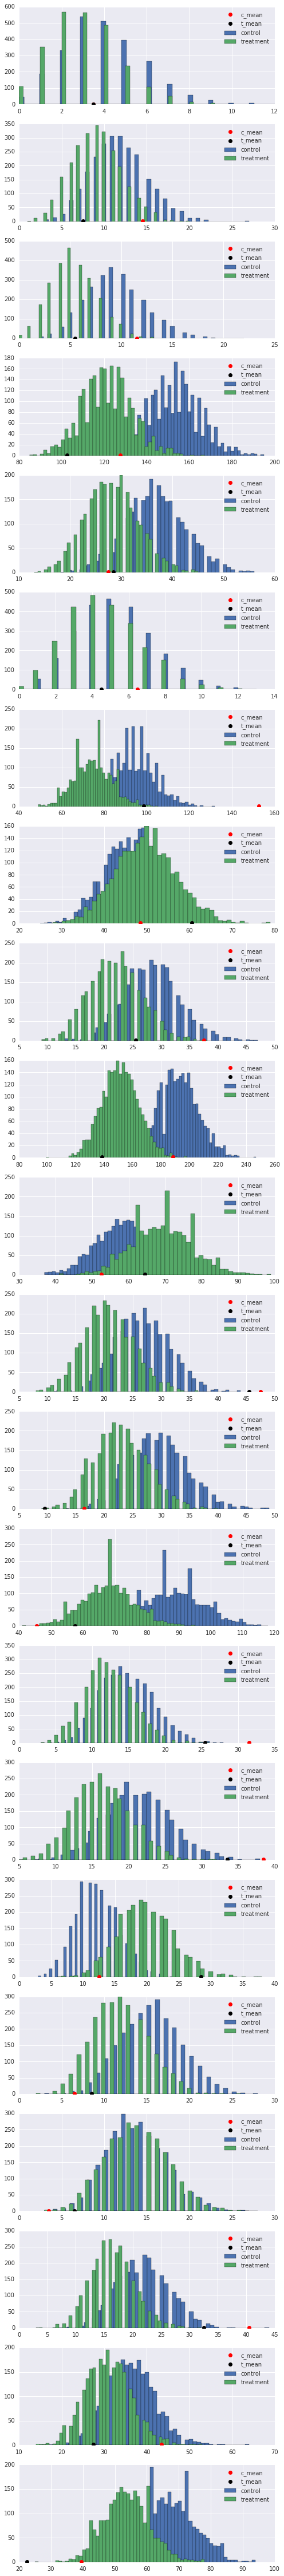

In [18]:
print('The following is a summary for model #3, where mu and delta are deterministic variables')
model_tester(bblock_survival3_trace[500:],varnames3,  bbsim3, bbmodel3_dic)

## Summary for model #4. Here delta and mu is stochastic.

The following is a summary for model #4, where mu and delta are stochastic variables

The DIC for this model is 466.63285


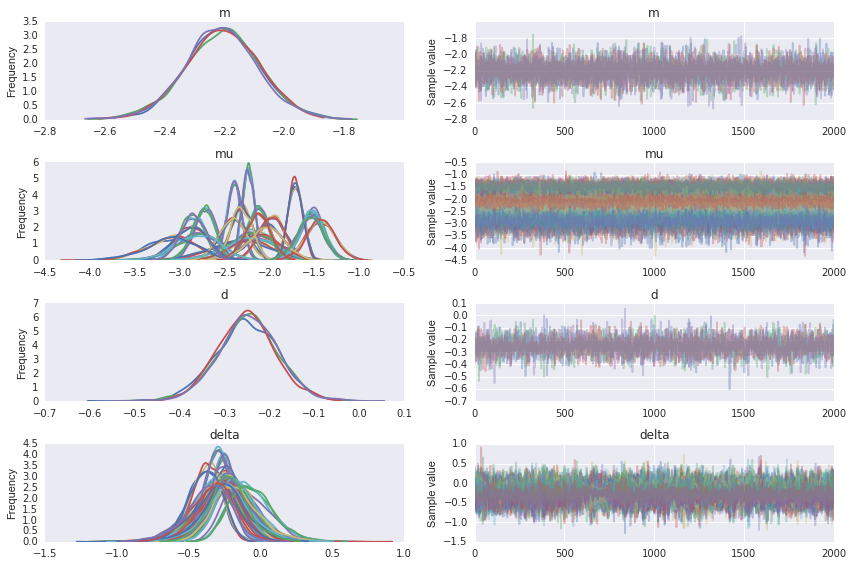

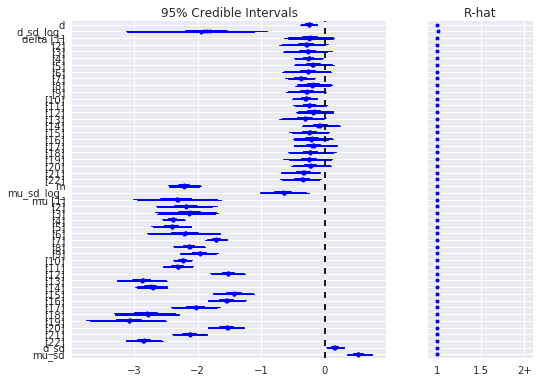

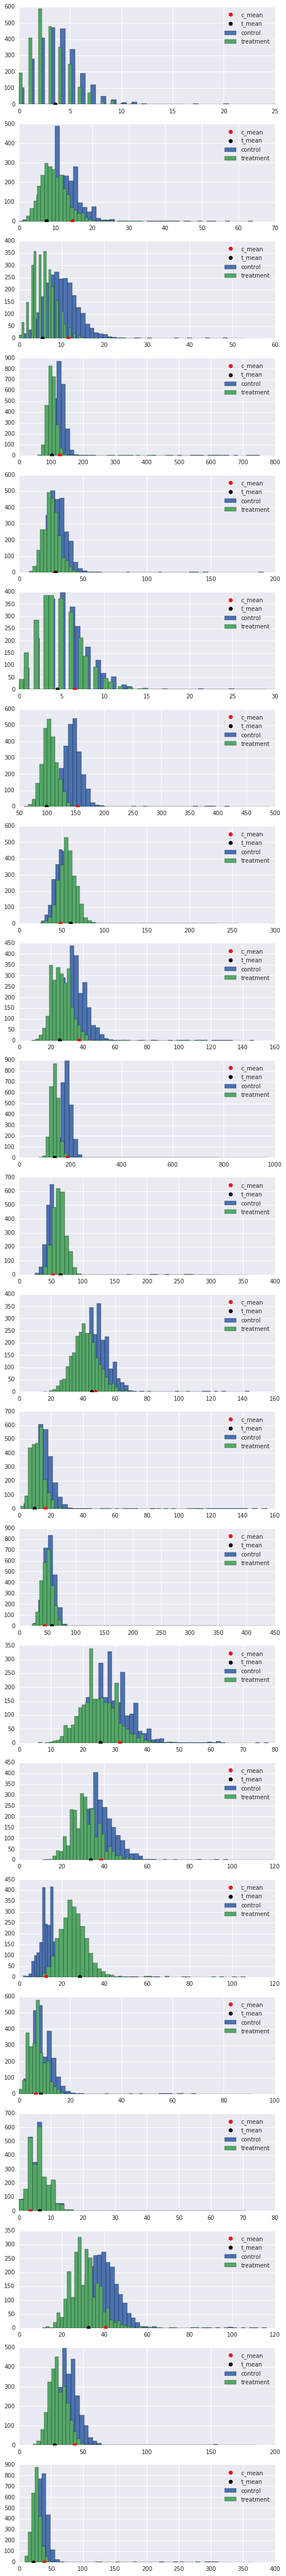

In [19]:
print('The following is a summary for model #4, where mu and delta are stochastic variables')
model_tester(bblock_survival4_trace[500:],varnames4,  bbsim4, bbmodel4_dic)